In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchgeo.datasets import MMFlood
from torchgeo.samplers import RandomGeoSampler
from torchgeo.samplers import RandomGeoSampler
from torchgeo.samplers import GridGeoSampler, Units
from tqdm import tqdm


In [2]:
from pathlib import Path

root = Path("/mnt/cephfs-mount/chenchen/mmflood")
count = 0

for event_dir in root.iterdir():
    if not event_dir.is_dir():
        continue
    
    s1_dir = event_dir / "s1_raw"
    if not s1_dir.exists():
        continue

    count += len(list(s1_dir.glob("*.tif")))

print("总共 patch 数量：", count)


总共 patch 数量： 1748


In [3]:
import rasterio
from pathlib import Path

tif_path = "/mnt/cephfs-mount/chenchen/mmflood/EMSR107-1/s1_raw/EMSR107-1-1.tif"

with rasterio.open(tif_path) as src:
    print("CRS       :", src.crs)
    print("Transform :", src.transform)
    print("Bounds    :", src.bounds)


CRS       : EPSG:4326
Transform : | 0.00, 0.00, 14.42|
| 0.00,-0.00, 45.73|
| 0.00, 0.00, 1.00|
Bounds    : BoundingBox(left=14.416132430999959, bottom=45.68617928533084, right=14.508332749000001, top=45.733552474999975)


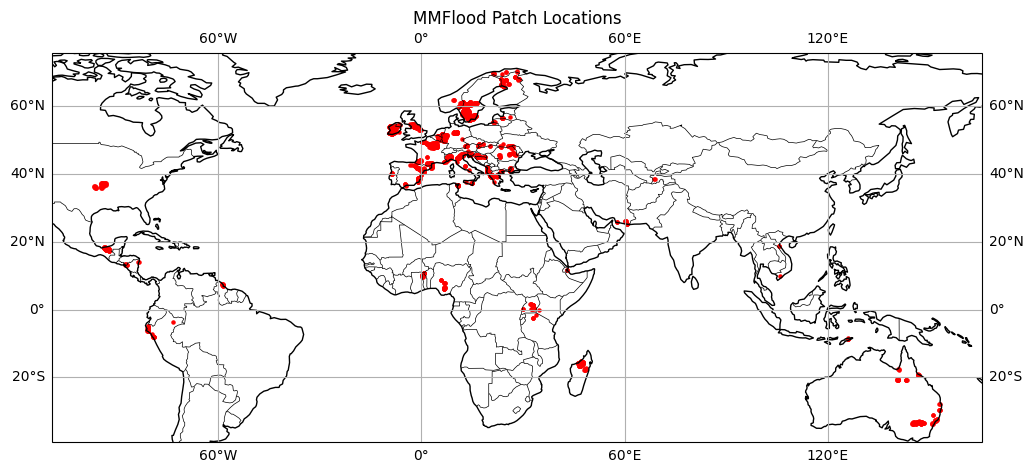

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# 添加海岸线和国界
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True)

# 叠加你的点
ax.scatter(df["lon"], df["lat"], s=5, c = 'red', transform=ccrs.PlateCarree())

ax.set_title("MMFlood Patch Locations")
plt.show()


In [9]:
from pathlib import Path
import rasterio
import pandas as pd

root = Path("/mnt/cephfs-mount/chenchen/mmflood")

records = []

for event_dir in root.iterdir():
    if not event_dir.is_dir():
        continue

    s1_dir = event_dir / "s1_raw"
    mask_dir = event_dir / "mask"
    if not s1_dir.exists() or not mask_dir.exists():
        continue

    for s1_path in s1_dir.glob("*.tif"):
        fname = s1_path.name
        m_path = mask_dir / fname
        if not m_path.exists():
            continue

        with rasterio.open(s1_path) as s1_src, rasterio.open(m_path) as m_src:
            s1_bands = s1_src.count
            s1_h, s1_w = s1_src.height, s1_src.width
            s1_dtype = s1_src.dtypes[0]      # 所有 band 一般一样
            s1_crs = s1_src.crs.to_string() if s1_src.crs else None
            # 分辨率（像素大小，单位度）
            s1_res_x, s1_res_y = s1_src.res

            m_bands = m_src.count
            m_h, m_w = m_src.height, m_src.width
            m_dtype = m_src.dtypes[0]

        records.append({
            "event": event_dir.name,
            "file": fname,
            "s1_bands": s1_bands,
            "s1_height": s1_h,
            "s1_width": s1_w,
            "s1_dtype": s1_dtype,
            "s1_crs": s1_crs,
            "s1_res_x": s1_res_x,
            "s1_res_y": s1_res_y,
            "mask_bands": m_bands,
            "mask_height": m_h,
            "mask_width": m_w,
            "mask_dtype": m_dtype,
        })

df = pd.DataFrame(records)
df.head()


event              file  s1_bands  s1_height  s1_width s1_dtype  \
0  EMSR332-6  EMSR332-6-17.tif         2       1280       557  float32   
1  EMSR332-6  EMSR332-6-16.tif         2       1213      1288  float32   
2  EMSR332-6   EMSR332-6-9.tif         2       1312      1318  float32   
3  EMSR332-6   EMSR332-6-0.tif         2        710       695  float32   
4  EMSR332-6   EMSR332-6-6.tif         2        490      1359  float32   

      s1_crs  s1_res_x  s1_res_y  mask_bands  mask_height  mask_width  \
0  EPSG:4326  0.000128   0.00009           1         1280         557   
1  EPSG:4326  0.000128   0.00009           1         1213        1288   
2  EPSG:4326  0.000128   0.00009           1         1312        1318   
3  EPSG:4326  0.000128   0.00009           1          710         695   
4  EPSG:4326  0.000128   0.00009           1          490        1359   

  mask_dtype  
0    float32  
1    float32  
2    float32  
3    float32  
4    float32

In [10]:
import rasterio
import numpy as np
from pathlib import Path

sample_mask = "/mnt/cephfs-mount/chenchen/mmflood/EMSR332-6/mask/EMSR332-6-17.tif"

with rasterio.open(sample_mask) as src:
    m = src.read(1)
    print("min:", np.nanmin(m), "max:", np.nanmax(m), "unique:", np.unique(m)[:10])


min: 0.0 max: 1.0 unique: [0. 1.]


In [12]:
from pathlib import Path
import rasterio
import pandas as pd

root = Path("/mnt/cephfs-mount/chenchen/mmflood")

sizes = []   # (H, W)

for event_dir in root.iterdir():
    if not event_dir.is_dir():
        continue

    s1_dir = event_dir / "s1_raw"
    mask_dir = event_dir / "mask"

    if not s1_dir.exists(): 
        continue

    for tif in s1_dir.glob("*.tif"):
        with rasterio.open(tif) as src:
            h, w = src.height, src.width
            sizes.append((h, w))

# === 转为 DataFrame ===
df_sizes = pd.DataFrame(sizes, columns=["H", "W"])

# === 分组统计 ===
size_counts = (
    df_sizes.groupby(["H", "W"])
            .size()
            .reset_index(name="count")
            .sort_values("count", ascending=False)
)

# 输出结果
print("===================================")
print("一共有多少张 patch：", len(df_sizes))
print("一共有多少种不同的尺寸：", size_counts.shape[0])
print("===================================")
print("前 20 个最常见的尺寸：")
print(size_counts.head(20))

# 如果想保存
# size_counts.to_csv("mmflood_all_patch_sizes.csv", index=False)


一共有多少张 patch： 1748
一共有多少种不同的尺寸： 1710
前 20 个最常见的尺寸：
         H     W  count
933    959   959      5
724    860  1194      3
1661  1861  1861      3
822    911   673      2
1236  1149  1149      2
1325  1224  1283      2
923    956   956      2
506    730   532      2
1346  1247  1434      2
365    685  1321      2
939    961   961      2
524    735   540      2
100    566   571      2
884    939   615      2
540    745   584      2
121    575   676      2
321    669   649      2
1401  1311  1353      2
1444  1370  1370      2
1046  1029  1457      2


In [13]:
min_h = df_sizes["H"].min()
max_h = df_sizes["H"].max()

min_w = df_sizes["W"].min()
max_w = df_sizes["W"].max()

print("最小高度 H_min =", min_h)
print("最大高度 H_max =", max_h)
print("最小宽度 W_min =", min_w)
print("最大宽度 W_max =", max_w)

# 同时看一下一些百分位（帮助选 crop）
print("\nH/W 的统计分布：")
print(df_sizes["H"].describe())
print(df_sizes["W"].describe())


最小高度 H_min = 480
最大高度 H_max = 2147
最小宽度 W_min = 467
最大宽度 W_max = 2313

H/W 的统计分布：
count    1748.000000
mean      993.452517
std       352.440703
min       480.000000
25%       708.000000
50%       926.000000
75%      1182.250000
max      2147.000000
Name: H, dtype: float64
count    1748.000000
mean      909.411899
std       378.746557
min       467.000000
25%       597.750000
50%       771.000000
75%      1149.250000
max      2313.000000
Name: W, dtype: float64


🔎 正在检测数据目录... 认定SAR目录为: sar
⏳ 正在搜索包含洪水的样本...
✅ 找到有效样本: EMSR520-0-1_0_0.tif

🎉 验证图片已保存为: check_result.png


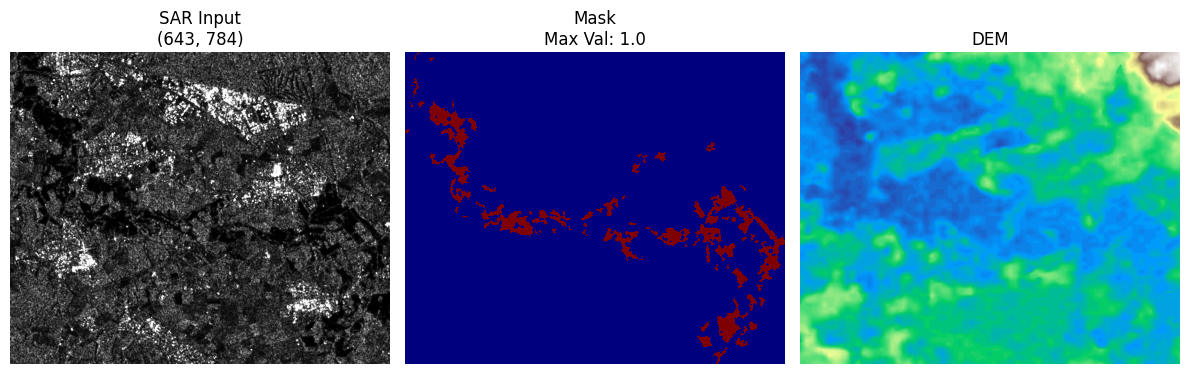

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff  # <--- 改用这个库
import glob

# 1. 设置你的数据路径 (保持不变)
DATA_ROOT = "/mnt/cephfs-mount/chenchen/mmflood_processed_github"
SPLIT = "test"

# 自动探测 SAR 文件夹名称
sar_dir_name = "sar" if os.path.exists(os.path.join(DATA_ROOT, SPLIT, "sar")) else "s1"
print(f"🔎 正在检测数据目录... 认定SAR目录为: {sar_dir_name}")

sar_path = os.path.join(DATA_ROOT, SPLIT, sar_dir_name)
mask_path = os.path.join(DATA_ROOT, SPLIT, "mask")
dem_path = os.path.join(DATA_ROOT, SPLIT, "dem")

def read_tif(path):
    try:
        # tifffile 读取非常直接，返回的就是 numpy array
        img = tiff.imread(path)
        
        # 处理多波段情况：如果有多个通道，默认取第一个通道可视化
        # SAR数据可能有 VV, VH 两个通道，Shape可能是 (H, W, C) 或 (C, H, W)
        if img.ndim == 3:
            # 假设通道在最后一维 (H, W, C)，取第0个
            if img.shape[2] < img.shape[0]: 
                return img[:, :, 0]
            # 假设通道在第一维 (C, H, W)
            else:
                return img[0, :, :]
        return img
    except Exception as e:
        print(f"读取错误 {path}: {e}")
        return None

# 3. 寻找有效样本 (逻辑不变)
print("⏳ 正在搜索包含洪水的样本...")
found_valid_sample = False
sample_file = ""

mask_files = glob.glob(os.path.join(mask_path, "*.tif"))
if len(mask_files) == 0:
    print(f"❌ 错误: 在 {mask_path} 下没找到任何 .tif 文件！")
    exit()

for f_path in mask_files[:200]:
    arr = read_tif(f_path)
    if arr is not None and np.max(arr) > 0:
        sample_file = os.path.basename(f_path)
        found_valid_sample = True
        print(f"✅ 找到有效样本: {sample_file}")
        break

if not found_valid_sample:
    print("⚠️ 未找到洪水样本，随机展示第一张。")
    sample_file = os.path.basename(mask_files[0])

# 4. 读取对应模态
img_sar = read_tif(os.path.join(sar_path, sample_file))
img_mask = read_tif(os.path.join(mask_path, sample_file))
img_dem = read_tif(os.path.join(dem_path, sample_file))

if img_sar is None or img_mask is None:
    print(f"❌ 错误: 无法找到对应的文件。请检查文件名匹配情况。")
    exit()

# 5. 绘图保存
plt.figure(figsize=(12, 4))

# SAR
plt.subplot(1, 3, 1)
if img_sar is not None:
    vmin, vmax = np.percentile(img_sar, [2, 98])
    plt.imshow(img_sar, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title(f"SAR Input\n{img_sar.shape}")
plt.axis('off')

# Mask
plt.subplot(1, 3, 2)
plt.imshow(img_mask, cmap='jet', interpolation='nearest')
plt.title(f"Mask\nMax Val: {np.max(img_mask)}")
plt.axis('off')

# DEM
plt.subplot(1, 3, 3)
if img_dem is not None:
    plt.imshow(img_dem, cmap='terrain')
    plt.title("DEM")
else:
    plt.text(0.5, 0.5, "No DEM", ha='center')
plt.axis('off')

output_filename = "check_result.png"
plt.tight_layout()
plt.savefig(output_filename)
print(f"\n🎉 验证图片已保存为: {output_filename}")

⏳ 正在 test 数据集中搜索包含洪水的样本...
✅ 找到有效样本: EMSR520-0-1_0_0.tif
⚠️ 模态 'Hydrography' 的数据未找到或读取失败: /mnt/cephfs-mount/chenchen/mmflood_processed_github/test/hydro/EMSR520-0-1_0_0.tif

🎉 增强版数据集成可视化图片已保存为: dataset_sample_visualization_enhanced.png


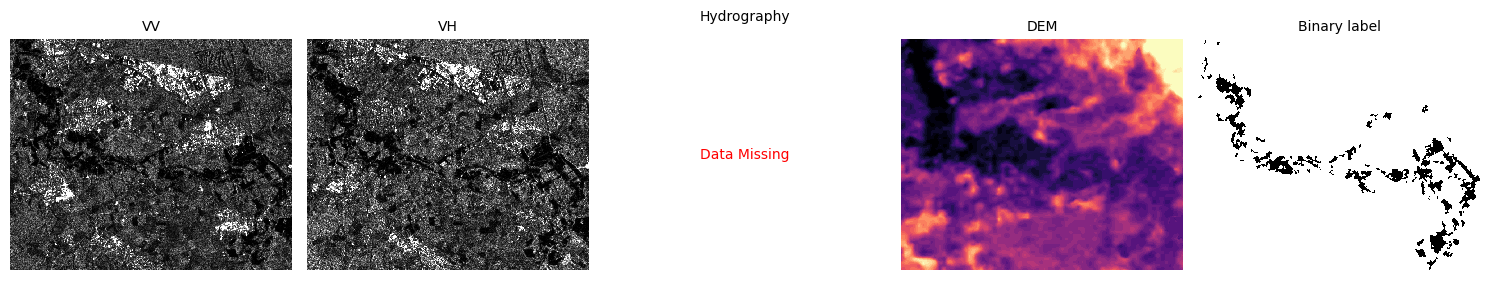

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import glob
import math

# --- 1. 配置你的数据路径 (保持不变) ---
DATA_ROOT = "/mnt/cephfs-mount/chenchen/mmflood_processed_github"
SPLIT = "test"

sar_dir_name = "sar" if os.path.exists(os.path.join(DATA_ROOT, SPLIT, "sar")) else "s1"
if not os.path.exists(os.path.join(DATA_ROOT, SPLIT, sar_dir_name)):
    print(f"❌ 错误: 未找到SAR数据目录 ({sar_dir_name})。请检查路径或文件夹名。")
    exit()

VV_PATH = os.path.join(DATA_ROOT, SPLIT, sar_dir_name)
VH_PATH = os.path.join(DATA_ROOT, SPLIT, sar_dir_name)
HYDRO_PATH = os.path.join(DATA_ROOT, SPLIT, "hydro")
DEM_PATH = os.path.join(DATA_ROOT, SPLIT, "dem")
MASK_PATH = os.path.join(DATA_ROOT, SPLIT, "mask")

MODALITIES = [
    {"name": "VV", "dir": VV_PATH, "cmap": "gray", "is_sar": True}, # 标记为SAR
    {"name": "VH", "dir": VH_PATH, "cmap": "gray", "is_sar": True}, # 标记为SAR
    {"name": "Hydrography", "dir": HYDRO_PATH, "cmap": "Blues", "is_sar": False},
    {"name": "DEM", "dir": DEM_PATH, "cmap": "magma", "is_sar": False},
    {"name": "Binary label", "dir": MASK_PATH, "cmap": "gray_r", "is_sar": False},
]

# --- 2. 读取 TIFF 文件的辅助函数 (保持不变) ---
def read_tif(path, band_index=0):
    try:
        img = tiff.imread(path)
        if img.ndim == 3:
            if img.shape[2] > band_index:
                return img[:, :, band_index]
            elif img.shape[0] > band_index:
                return img[band_index, :, :]
        return img
    except Exception as e:
        # print(f"读取文件 '{path}' 错误: {e}")
        return None

# --- 3. 寻找一个有洪水的样本 (保持不变) ---
print(f"⏳ 正在 {SPLIT} 数据集中搜索包含洪水的样本...")
found_valid_sample_file = None
mask_files = glob.glob(os.path.join(MASK_PATH, "*.tif"))

if not mask_files:
    print(f"❌ 错误: 在 '{MASK_PATH}' 路径下未找到任何 .tif 文件。请检查路径。")
    exit()

for f_path in mask_files[:500]:
    img = read_tif(f_path)
    if img is not None and np.max(img) > 0:
        found_valid_sample_file = os.path.basename(f_path)
        print(f"✅ 找到有效样本: {found_valid_sample_file}")
        break

if found_valid_sample_file is None:
    print("⚠️ 未在前500个样本中找到包含洪水的Mask。将随机选择第一个Mask文件进行可视化。")
    found_valid_sample_file = os.path.basename(mask_files[0])

# --- 4. 加载所有模态的数据 (保持不变) ---
loaded_data = {}
for modality_info in MODALITIES:
    modality_name = modality_info["name"]
    modality_dir = modality_info["dir"]
    
    file_path = os.path.join(modality_dir, found_valid_sample_file)
    
    if modality_name == "VV":
        data = read_tif(file_path, band_index=0)
    elif modality_name == "VH":
        data = read_tif(file_path, band_index=1)
    else:
        data = read_tif(file_path)
    
    if data is not None:
        loaded_data[modality_name] = data
    else:
        print(f"⚠️ 模态 '{modality_name}' 的数据未找到或读取失败: {file_path}")
        loaded_data[modality_name] = None

# --- 5. 绘制和保存图像 (此处有修改) ---
num_cols = len(MODALITIES)
num_rows = 1

if not loaded_data:
    print("❌ 未加载到任何有效数据，无法绘图。请检查路径和文件。")
    exit()

fig_width = num_cols * 3
fig_height = num_rows * 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

if num_cols == 1:
    axes = [axes]

for i, modality_info in enumerate(MODALITIES):
    modality_name = modality_info["name"]
    modality_data = loaded_data.get(modality_name)
    ax = axes[i]

    ax.set_title(modality_name, fontsize=10)
    ax.axis('off')

    if modality_data is not None:
        display_data = modality_data
        
        # --- 关键修改：对 SAR 图像进行对数变换和归一化 ---
        if modality_info["is_sar"]:
            # 避免对数0，加一个很小的值
            display_data = np.log1p(display_data) 
            # 再次使用百分位数截断，效果会好很多
            vmin, vmax = np.percentile(display_data, [2, 98])
            
        elif modality_name == "DEM": # DEM 也可能需要拉伸
            vmin, vmax = np.percentile(display_data, [2, 98])
            
        else: # 其他数据（Hydrography, Mask）通常不需要复杂处理
            vmin, vmax = None, None # 让 imshow 自动处理
        
        im = ax.imshow(display_data, cmap=modality_info["cmap"], vmin=vmin, vmax=vmax, interpolation='nearest')
        
    else:
        ax.text(0.5, 0.5, "Data Missing", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red')

plt.tight_layout()
output_filename = "dataset_sample_visualization_enhanced.png" # 更改文件名
plt.savefig(output_filename, dpi=300)
print(f"\n🎉 增强版数据集成可视化图片已保存为: {output_filename}")

📂 正在扫描数据目录: /mnt/cephfs-mount/chenchen/mmflood
🔎 发现了 333 个灾害事件文件夹 (EMSR...)
🎲 正在随机抽取 3 个样本...


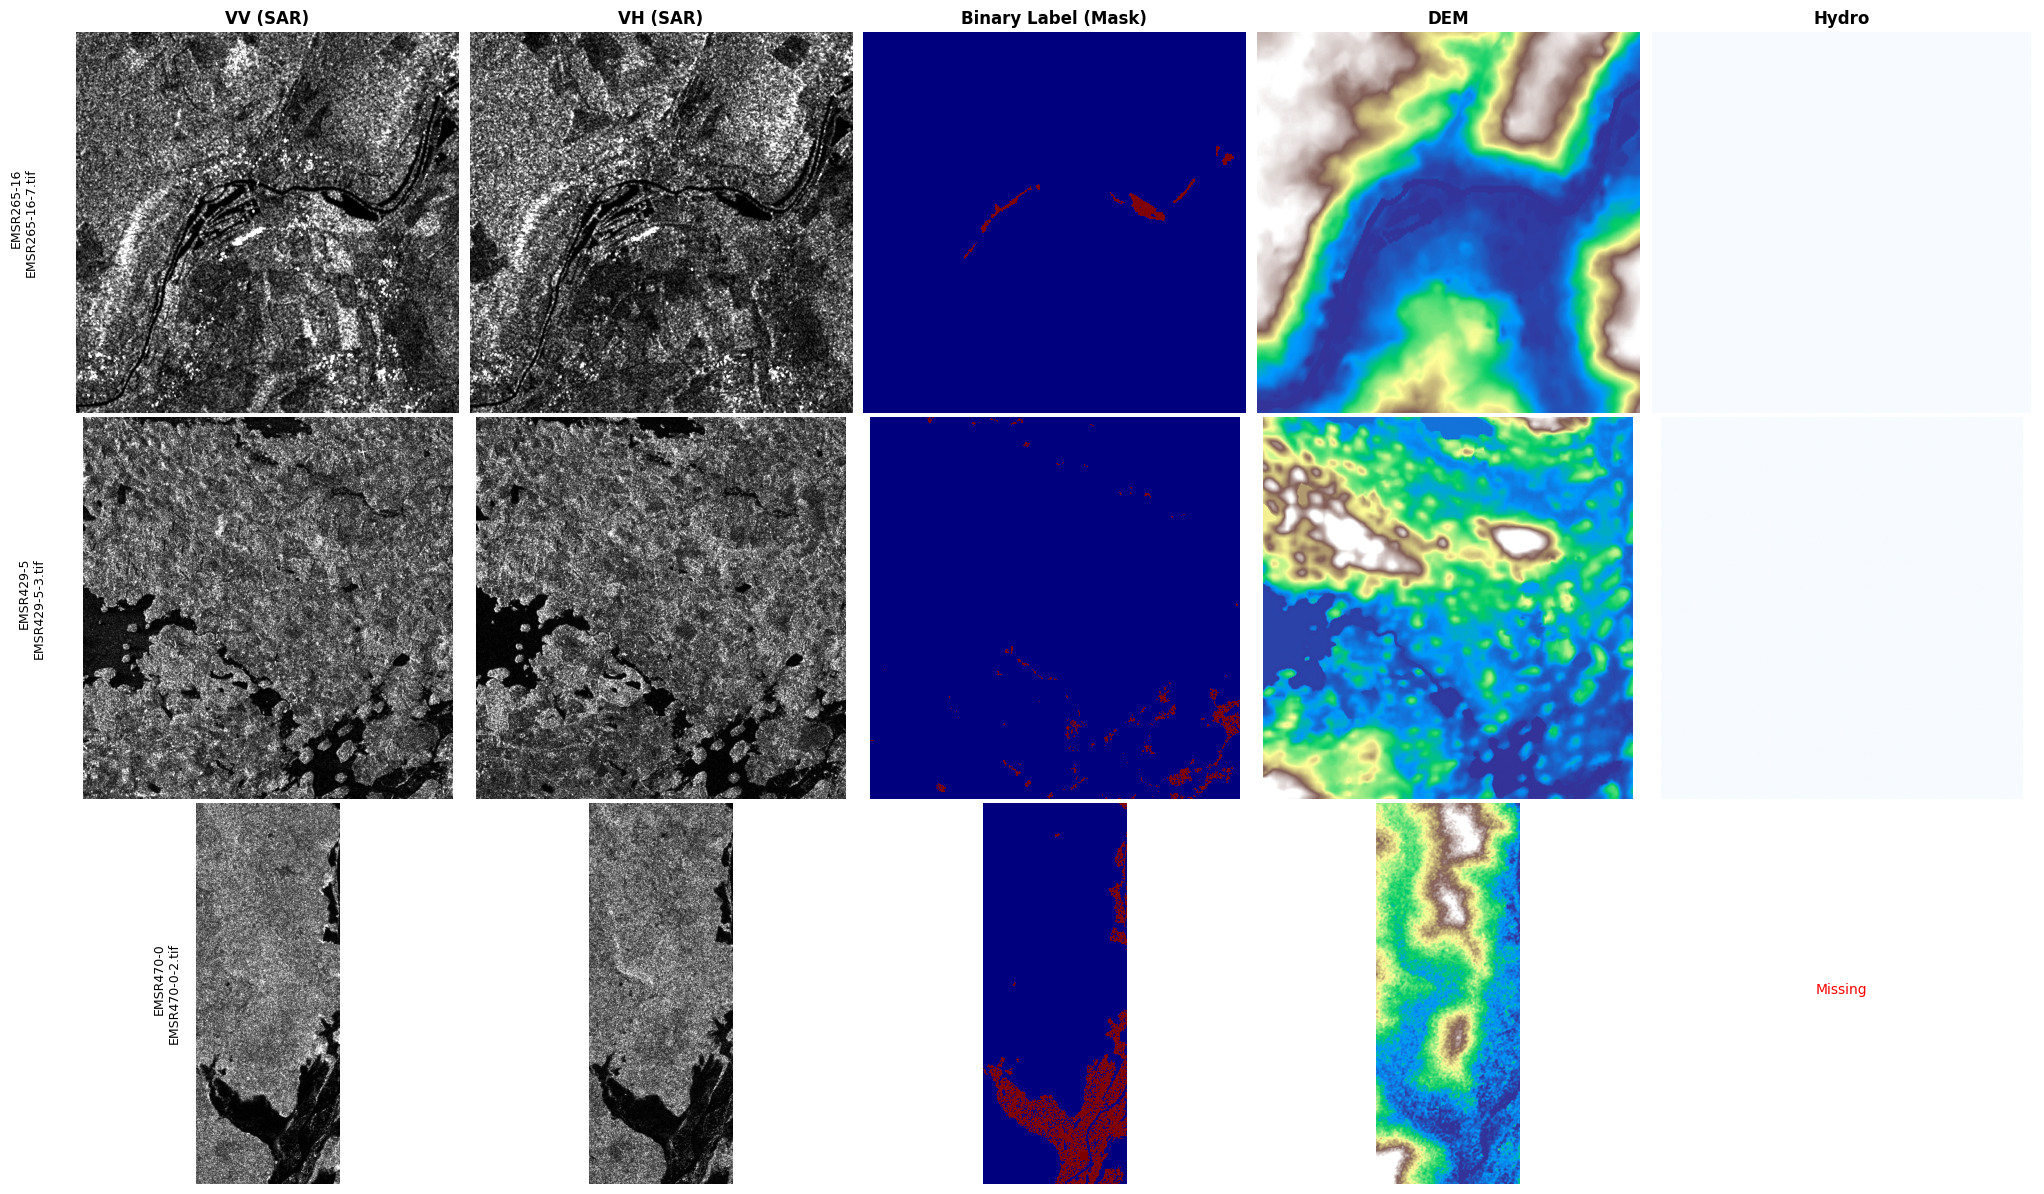

In [17]:
import os
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

# --- 1. 配置原始数据路径 ---
# 这里的路径指向包含 'activations' 文件夹的上级目录，或者是 'activations' 本身
# 根据你的描述，我假设 activations 在这个目录下
ROOT_DIR = "/mnt/cephfs-mount/chenchen/mmflood" 
ACTIVATIONS_DIR = os.path.join(ROOT_DIR)

# 如果你的目录结构里直接就是 EMSR 文件夹，请解开下面这行的注释：
# ACTIVATIONS_DIR = ROOT_DIR 

print(f"📂 正在扫描数据目录: {ACTIVATIONS_DIR}")

# --- 2. 辅助函数 ---
def read_tif(path, band_index=None):
    if not os.path.exists(path):
        return None
    try:
        img = tiff.imread(path)
        # 处理多波段: (C, H, W) 或 (H, W, C)
        if band_index is not None and img.ndim == 3:
            if img.shape[0] < img.shape[2]: # (C, H, W)
                return img[band_index, :, :]
            else: # (H, W, C)
                return img[:, :, band_index]
        return img
    except Exception as e:
        print(f"⚠️ 读取失败 {path}: {e}")
        return None

def normalize_sar(img):
    """对SAR图像进行对数变换和截断归一化，防止全黑"""
    if img is None: return None
    # 1. 对数变换 (Log transform) 压缩动态范围
    img_log = np.log1p(img)
    # 2. 截断 (Percentile clipping) 去除极值
    vmin, vmax = np.percentile(img_log, [2, 98])
    return np.clip((img_log - vmin) / (vmax - vmin + 1e-6), 0, 1)

# --- 3. 收集所有可用的样本 ---
# 我们遍历所有 EMSRxxx 文件夹，收集所有 mask 文件的路径作为索引
all_events = [d for d in os.listdir(ACTIVATIONS_DIR) if os.path.isdir(os.path.join(ACTIVATIONS_DIR, d))]
print(f"🔎 发现了 {len(all_events)} 个灾害事件文件夹 (EMSR...)")

if not all_events:
    print("❌ 未找到任何事件文件夹，请检查 ROOT_DIR 路径是否正确。")
    exit()

# --- 4. 随机抽取 3 个样本 ---
NUM_SAMPLES = 3
samples_to_plot = []

print(f"🎲 正在随机抽取 {NUM_SAMPLES} 个样本...")

# 为了保证多样性，我们尝试随机选事件，再从事件里随机选图
for _ in range(NUM_SAMPLES * 5): # 多试几次以防某个事件没文件
    if len(samples_to_plot) >= NUM_SAMPLES:
        break
        
    event_name = random.choice(all_events)
    event_dir = os.path.join(ACTIVATIONS_DIR, event_name)
    
    # 原始数据结构: event_dir/mask/*.tif
    mask_dir = os.path.join(event_dir, "mask")
    if not os.path.exists(mask_dir): continue
    
    files = glob.glob(os.path.join(mask_dir, "*.tif"))
    if not files: continue
    
    # 选中一个文件
    selected_file = random.choice(files)
    filename = os.path.basename(selected_file)
    
    # 避免重复
    if any(s['filename'] == filename for s in samples_to_plot):
        continue
        
    samples_to_plot.append({
        "event": event_name,
        "filename": filename,
        "base_dir": event_dir
    })

if not samples_to_plot:
    print("❌ 无法找到任何有效的 .tif 文件，请检查目录结构。")
    exit()

# --- 5. 绘图 ---
# 布局: 行=样本, 列=模态 (VV, VH, Mask, DEM, Hydro)
cols = ["VV (SAR)", "VH (SAR)", "Binary Label (Mask)", "DEM", "Hydro"]
fig, axes = plt.subplots(len(samples_to_plot), 5, figsize=(20, 4 * len(samples_to_plot)))

# 如果只有一行，axes 需要转为二维数组方便索引
if len(samples_to_plot) == 1: axes = np.expand_dims(axes, axis=0)

for i, sample in enumerate(samples_to_plot):
    event_dir = sample['base_dir']
    fname = sample['filename']
    
    # 构造各个模态的路径
    # 注意: 原始数据中 SAR 通常在 's1_raw' 文件夹
    p_s1 = os.path.join(event_dir, "s1_raw", fname)
    p_mask = os.path.join(event_dir, "mask", fname)
    p_dem = os.path.join(event_dir, "DEM", fname) # 注意有些系统区分大小写
    p_hydro = os.path.join(event_dir, "hydro", fname)
    
    # 读取数据
    # s1_raw 通常包含两个波段: 0=VV, 1=VH
    img_s1_vv = read_tif(p_s1, band_index=0)
    img_s1_vh = read_tif(p_s1, band_index=1)
    img_mask = read_tif(p_mask)
    img_dem = read_tif(p_dem)
    img_hydro = read_tif(p_hydro)
    
    # 准备一行的数据
    row_data = [
        (img_s1_vv, 'gray', True),   # VV, is_sar=True
        (img_s1_vh, 'gray', True),   # VH, is_sar=True
        (img_mask, 'jet', False),    # Mask
        (img_dem, 'terrain', False), # DEM
        (img_hydro, 'Blues', False)  # Hydro
    ]
    
    for j, (img, cmap, is_sar) in enumerate(row_data):
        ax = axes[i, j]
        
        if img is not None:
            if is_sar:
                # 应用 SAR 增强
                display_img = normalize_sar(img)
                ax.imshow(display_img, cmap=cmap)
            elif cmap == 'jet': # Mask
                ax.imshow(img, cmap=cmap, interpolation='nearest')
            else:
                # DEM / Hydro 自动归一化
                vmin, vmax = np.percentile(img, [2, 98]) if img.max() > img.min() else (None, None)
                ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            ax.text(0.5, 0.5, "Missing", ha='center', color='red')
            # 尝试兼容文件名大小写问题 (linux对大小写敏感)
            if j == 3: ax.set_title("DEM missing")
            
        ax.axis('off')
        
        # 仅在第一行显示列标题
        if i == 0:
            ax.set_title(cols[j], fontsize=12, fontweight='bold')
            
    # 在每行左侧显示文件名
    axes[i, 0].text(-0.1, 0.5, f"{sample['event']}\n{fname}", 
                    transform=axes[i, 0].transAxes, va='center', ha='right', fontsize=9, rotation=90)

plt.subplots_adjust(
    left=0.01, right=0.99, top=0.98, bottom=0.02,
    hspace=0.01, wspace=0.02
)



In [10]:
import os
import random 
from pathlib import Path

import rasterio
import numpy as np

ROOT = Path("/mnt/cephfs-mount/chenchen/mmflood_processed_github")
splits = ["train", "val", "test"]
modalities = ["sar", "dem", "mask", "images"]  # 如果没有 images 就先删掉

def list_stems(dir_path):
    if not dir_path.exists():
        return set()
    return {p.name for p in dir_path.glob("*.tif")}

for split in splits:
    print(f"\n===== Checking split: {split} =====")
    split_root = ROOT / split

    # 1) 文件名一致性
    stems_per_mod = {}
    for mod in modalities:
        mod_dir = split_root / mod
        if mod_dir.exists():
            stems_per_mod[mod] = list_stems(mod_dir)
            print(f"{mod}: {len(stems_per_mod[mod])} files")
        else:
            print(f"{mod}: (not found)")

    # 只对存在的模态做交集比较
    mods = list(stems_per_mod.keys())
    base_mod = mods[0]
    base_set = stems_per_mod[base_mod]
    for mod in mods[1:]:
        diff1 = base_set - stems_per_mod[mod]
        diff2 = stems_per_mod[mod] - base_set
        print(f"\nCompare {base_mod} vs {mod}:")
        print(f"  {base_mod} only: {len(diff1)}")
        print(f"  {mod} only: {len(diff2)}")
        if len(diff1) > 0:
            print("  Example only-in-base:", list(diff1)[:5])
        if len(diff2) > 0:
            print("  Example only-in-mod :", list(diff2)[:5])

    # 2) 抽样检查尺寸 & dtype & mask 值域
    if base_set:
        print("\nRandom sample check:")
        sample_files = random.sample(list(base_set), min(5, len(base_set)))
        for fname in sample_files:
            print(f"\n--- {fname} ---")
            for mod in mods:
                fpath = split_root / mod / fname
                with rasterio.open(fpath) as src:
                    arr = src.read()
                    print(
                        f"{mod}: shape={arr.shape}, dtype={arr.dtype}, "
                        f"min={arr.min()}, max={arr.max()}"
                    )
                    if mod == "mask":
                        uniq = np.unique(arr)
                        print(f"  unique values in mask: {uniq}")



===== Checking split: train =====
sar: 6181 files
dem: 6181 files
mask: 6181 files
images: 6181 files

Compare sar vs dem:
  sar only: 0
  dem only: 0

Compare sar vs mask:
  sar only: 0
  mask only: 0

Compare sar vs images:
  sar only: 0
  images only: 0

Random sample check:

--- EMSR192-2-1_0_38.tif ---
sar: shape=(2, 512, 512), dtype=float32, min=0.0004239087284076959, max=2.469886302947998
dem: shape=(1, 512, 512), dtype=float32, min=92.0, max=139.0
mask: shape=(1, 512, 512), dtype=float32, min=0.0, max=1.0
  unique values in mask: [0. 1.]
images: shape=(2, 512, 512), dtype=float32, min=0.0004239087284076959, max=2.469886302947998

--- EMSR424-4-9_453_172.tif ---
sar: shape=(2, 512, 512), dtype=float32, min=0.0004239087284076959, max=1.4017037153244019
dem: shape=(1, 512, 512), dtype=float32, min=751.0, max=962.0
mask: shape=(1, 512, 512), dtype=float32, min=0.0, max=1.0
  unique values in mask: [0. 1.]
images: shape=(2, 512, 512), dtype=float32, min=0.0004239087284076959, max=1